## Copy

In this task, a sequence of bit vectors is provided to the model. The input sequence starts with a reserved start vector, then some random binary bit vectors, followed by a reserved stop vector. The model is expected to start reproducing the exact input bit vectors immediately after observing the stop vector.

In [1]:
from util import *
from dnc_lstm import DNC
from dnc_ff import DNCFF
from autograd import grad
from autograd.misc.optimizers import rmsprop, adam

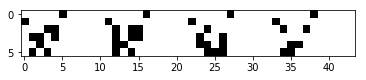

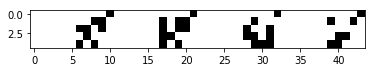

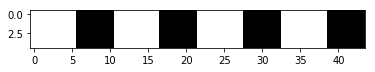

In [2]:
def seq(seq_len, seq_width):
    """
    Implements the copy task - section 4.1 from the NTM paper.
    Returns inputs, outputs, and a mask for loss calculation
    """
    rand_tile = np.random.randint(2, size=(seq_len, seq_width))
    inputs = np.zeros((seq_len*2+3, seq_width+2))
    inputs[0,1] = 1
    inputs[seq_len+1,0] = 1
    inputs[1:seq_len+1, 2:] = rand_tile
    targets = np.zeros((seq_len*2+3, seq_width+1))
    targets[-1,0] = 1
    targets[seq_len+2:-1, 1:] = rand_tile
    mask = np.zeros((seq_len*2+3, seq_width+1))
    mask[seq_len+2:,:] = 1
    return inputs, targets, mask

def long_copy(seq_len, seq_width, repeat=4):
    inputs, targets, masks = [], [], []
    for i in range(repeat):
        inpt, tar, mask = seq(seq_len, seq_width)
        inputs.append(inpt)
        targets.append(tar)
        masks.append(mask)
    inputs = np.vstack(inputs)
    targets = np.vstack(targets)
    masks = np.vstack(masks)
    return inputs, targets, masks

# print seq(4, 4)
for item in long_copy(4,4):
    display(item.T)

Training DNC...
('Iteration', 0, 'Train loss:', 0.31520250944989209)
Test loss:  0.315083656821
Input


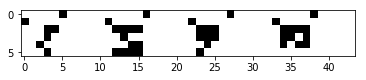

Target


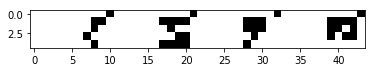

Predicted


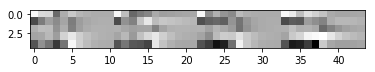

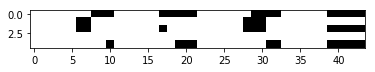

('Iteration', 1000, 'Train loss:', 0.19936718398781517)
Test loss:  0.201734670809
Input


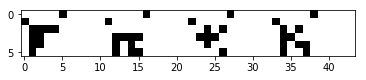

Target


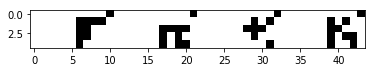

Predicted


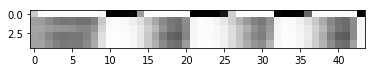

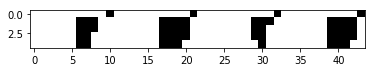

('Iteration', 2000, 'Train loss:', 0.18755471596228346)
Test loss:  0.190894785629
Input


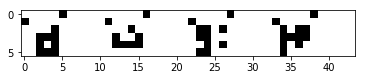

Target


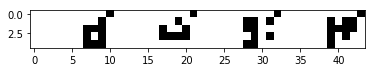

Predicted


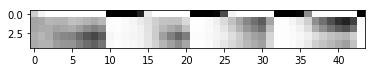

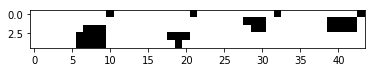

('Iteration', 3000, 'Train loss:', 0.17805099587347026)
Test loss:  0.178434588682
Input


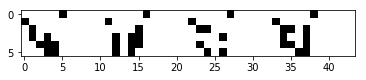

Target


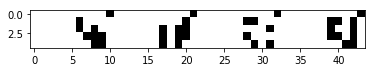

Predicted


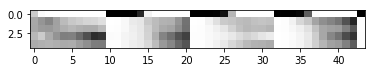

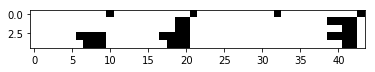

('Iteration', 4000, 'Train loss:', 0.16024890435614003)
Test loss:  0.175957985418
Input


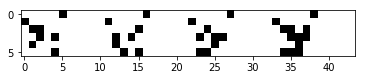

Target


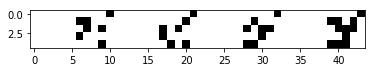

Predicted


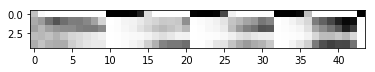

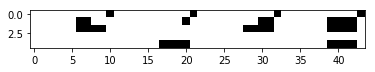

('Iteration', 5000, 'Train loss:', 0.18196779304307933)
Test loss:  0.127123609116
Input


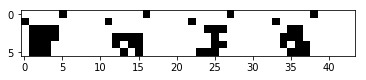

Target


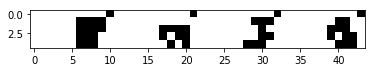

Predicted


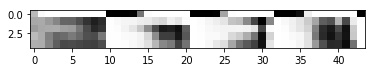

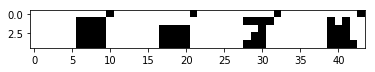

('Iteration', 6000, 'Train loss:', 0.13192690104558508)
Test loss:  0.140642717868
Input


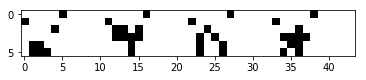

Target


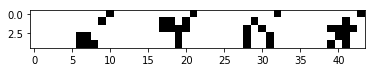

Predicted


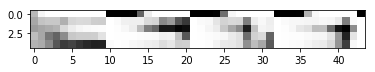

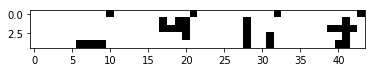

('Iteration', 7000, 'Train loss:', 0.14880993354493016)
Test loss:  0.130222515778
Input


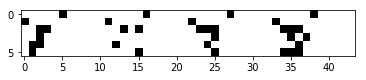

Target


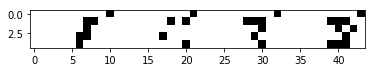

Predicted


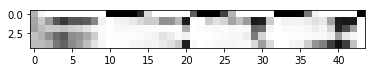

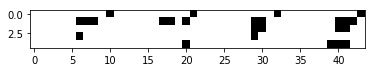

('Iteration', 8000, 'Train loss:', 0.12823290638718207)
Test loss:  0.157793531263
Input


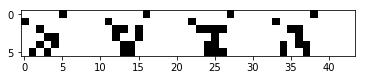

Target


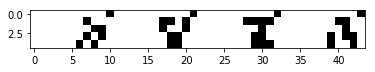

Predicted


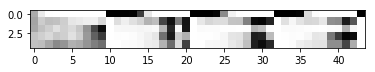

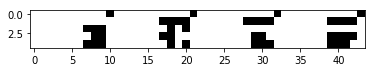

('Iteration', 9000, 'Train loss:', 0.13852898931302943)
Test loss:  0.104716482577
Input


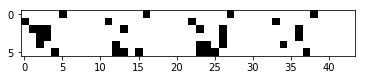

Target


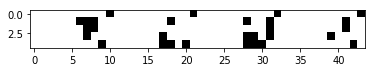

Predicted


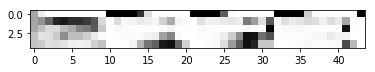

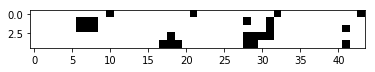

('Iteration', 10000, 'Train loss:', 0.089740990203694013)
Test loss:  0.112272159405
Input


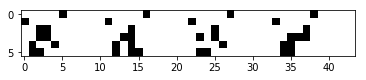

Target


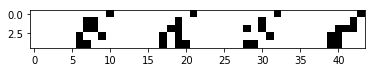

Predicted


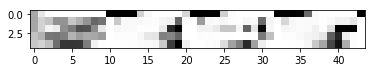

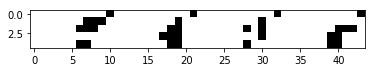

('Iteration', 11000, 'Train loss:', 0.12151497096647494)
Test loss:  0.135573828537
Input


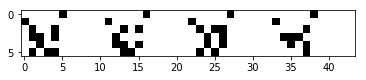

Target


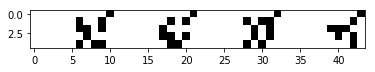

Predicted


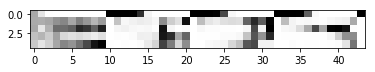

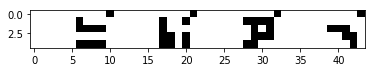

('Iteration', 12000, 'Train loss:', 0.0817904983275132)
Test loss:  0.0887915845921
Input


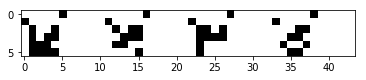

Target


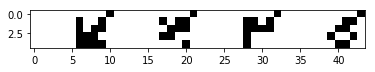

Predicted


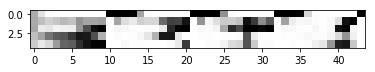

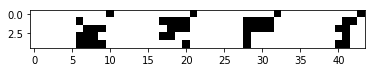

('Iteration', 13000, 'Train loss:', 0.089390510585651631)
Test loss:  0.0898698806995
Input


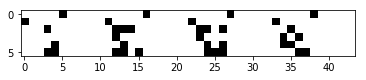

Target


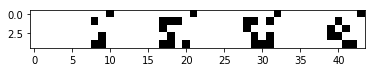

Predicted


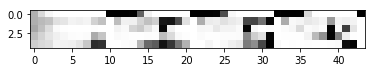

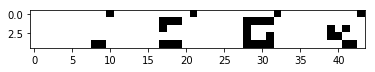

('Iteration', 14000, 'Train loss:', 0.085105448502944755)
Test loss:  0.119322694559
Input


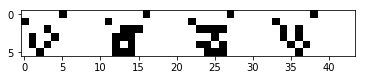

Target


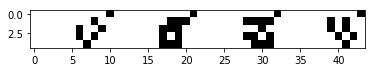

Predicted


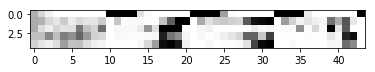

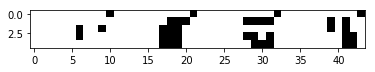

('Iteration', 15000, 'Train loss:', 0.054399590476895021)
Test loss:  0.0747607579907
Input


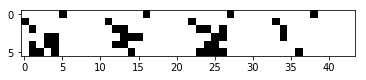

Target


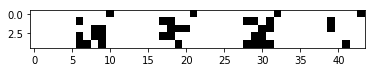

Predicted


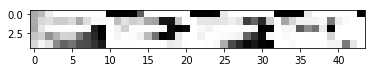

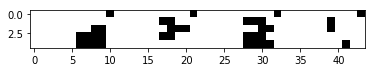

('Iteration', 16000, 'Train loss:', 0.070919105758451048)
Test loss:  0.0702330614391
Input


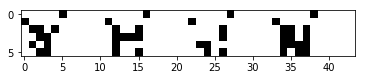

Target


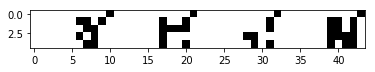

Predicted


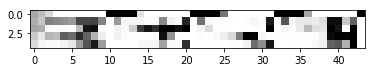

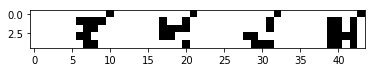

('Iteration', 17000, 'Train loss:', 0.049437267227821755)
Test loss:  0.0477989020835
Input


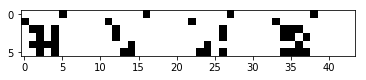

Target


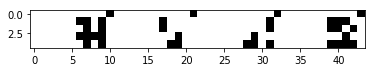

Predicted


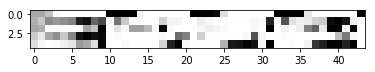

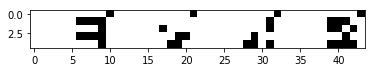

('Iteration', 18000, 'Train loss:', 0.065049157486874551)
Test loss:  0.0782081901269
Input


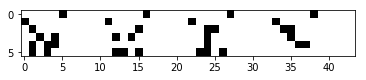

Target


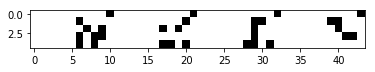

Predicted


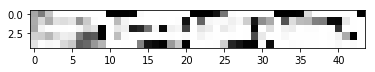

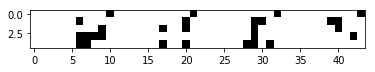

('Iteration', 19000, 'Train loss:', 0.08170738863817481)
Test loss:  0.0693999117631
Input


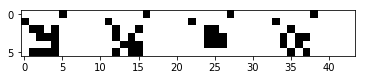

Target


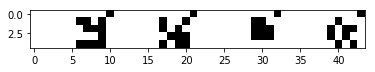

Predicted


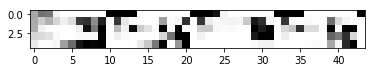

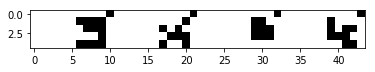

('Iteration', 20000, 'Train loss:', 0.06531481920859275)
Test loss:  0.0841959353001
Input


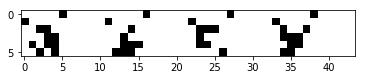

Target


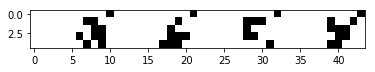

Predicted


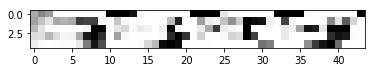

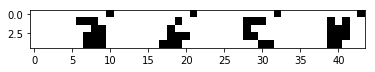

('Iteration', 21000, 'Train loss:', 0.048154780927270373)
Test loss:  0.0700193431933
Input


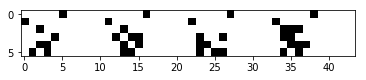

Target


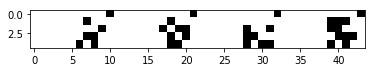

Predicted


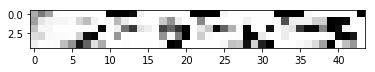

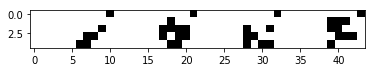

('Iteration', 22000, 'Train loss:', 0.050894650579163474)
Test loss:  0.0406157891305
Input


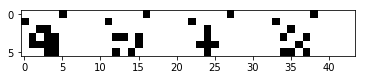

Target


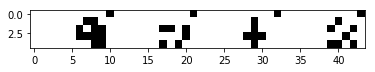

Predicted


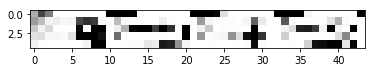

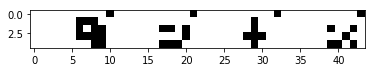

('Iteration', 23000, 'Train loss:', 0.054262078375578011)
Test loss:  0.0165748900436
Input


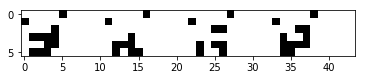

Target


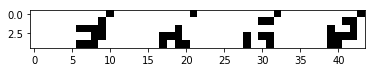

Predicted


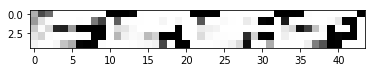

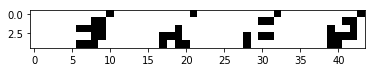

('Iteration', 24000, 'Train loss:', 0.039445005689946758)
Test loss:  0.0329827080588
Input


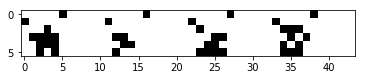

Target


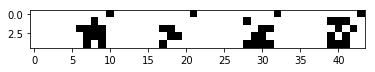

Predicted


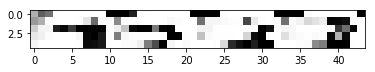

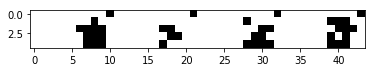

('Iteration', 25000, 'Train loss:', 0.020445644640477652)
Test loss:  0.0289346104634
Input


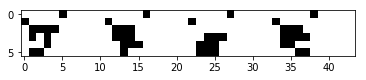

Target


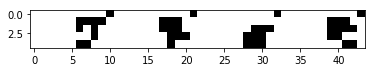

Predicted


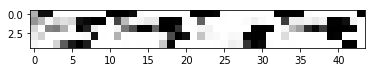

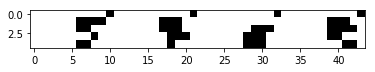

('Iteration', 26000, 'Train loss:', 0.066221880988299578)
Test loss:  0.00871469959012
Input


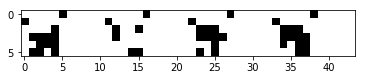

Target


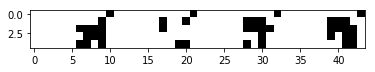

Predicted


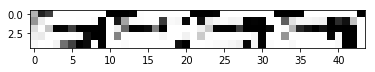

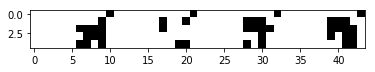

('Iteration', 27000, 'Train loss:', 0.0088328803489172488)
Test loss:  0.0105256380507
Input


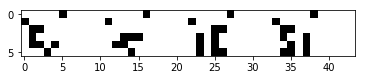

Target


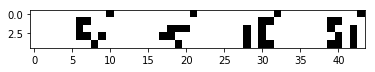

Predicted


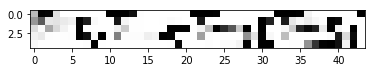

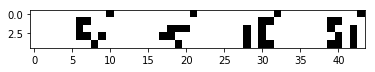

('Iteration', 28000, 'Train loss:', 0.0078989640284959396)
Test loss:  0.0151884558554
Input


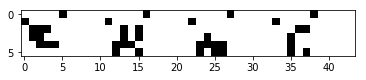

Target


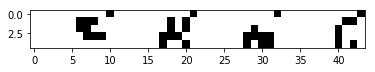

Predicted


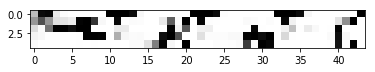

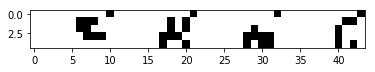

('Iteration', 29000, 'Train loss:', 0.026354378661679504)
Test loss:  0.00986298045306
Input


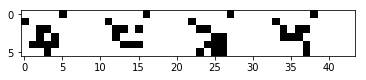

Target


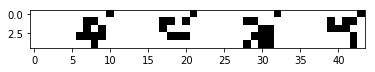

Predicted


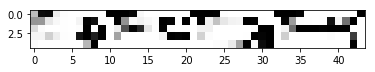

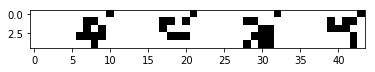

('Iteration', 30000, 'Train loss:', 0.0059252900222797134)
Test loss:  0.00769107631818
Input


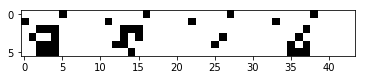

Target


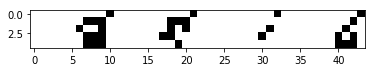

Predicted


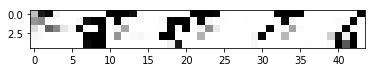

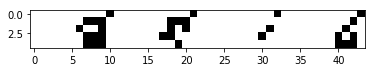

('Iteration', 31000, 'Train loss:', 0.0083135318895539746)
Test loss:  0.00835590792629
Input


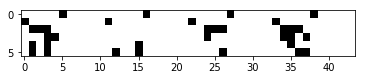

Target


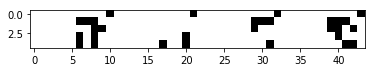

Predicted


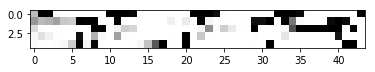

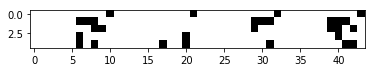

('Iteration', 32000, 'Train loss:', 0.0086480355453814346)
Test loss:  0.00169472997241
Input


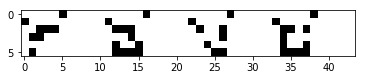

Target


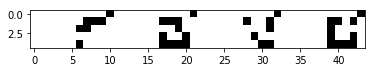

Predicted


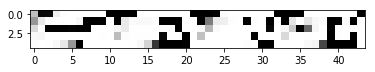

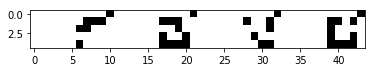

('Iteration', 33000, 'Train loss:', 0.0010651835962192692)
Test loss:  0.0161783803715
Input


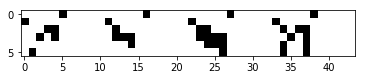

Target


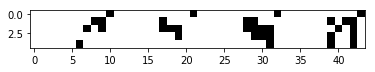

Predicted


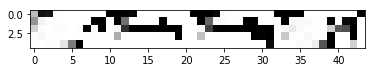

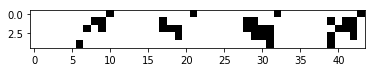

('Iteration', 34000, 'Train loss:', 0.010930146343676927)
Test loss:  0.00980899097515
Input


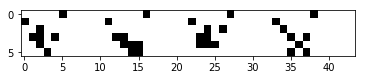

Target


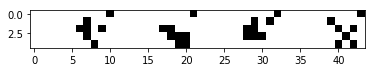

Predicted


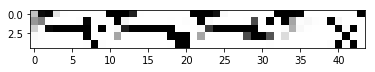

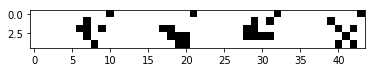

('Iteration', 35000, 'Train loss:', 0.0011261274995185608)
Test loss:  0.00323038922999
Input


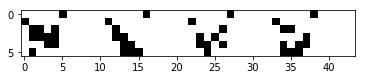

Target


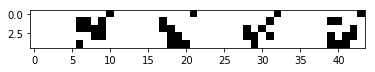

Predicted


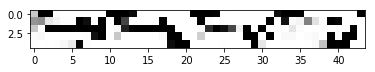

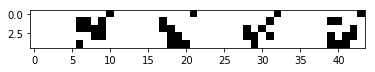

('Iteration', 36000, 'Train loss:', 0.0016028344413625529)
Test loss:  0.00283884098237
Input


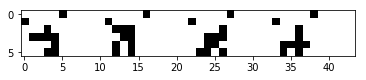

Target


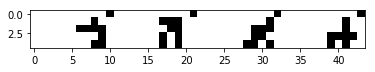

Predicted


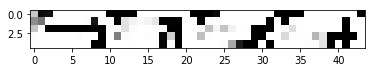

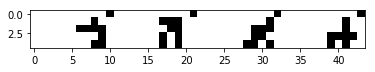

('Iteration', 37000, 'Train loss:', 0.0021134414878865807)
Test loss:  0.0154829629013
Input


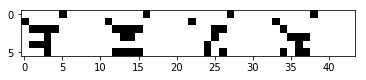

Target


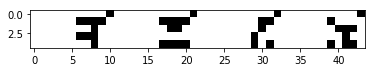

Predicted


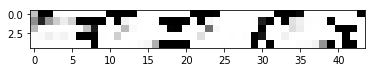

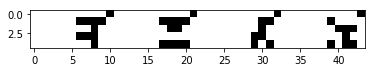

('Iteration', 38000, 'Train loss:', 0.003169715718017059)
Test loss:  0.000671858075319
Input


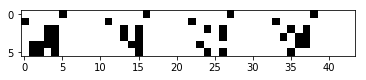

Target


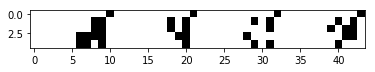

Predicted


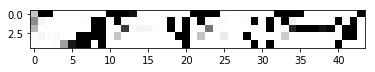

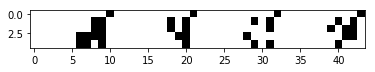

('Iteration', 39000, 'Train loss:', 0.00048862922671342286)
Test loss:  0.000227628817031
Input


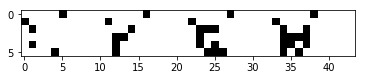

Target


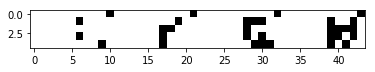

Predicted


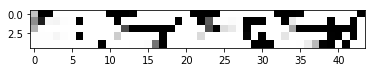

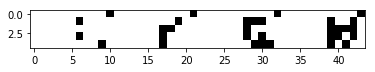

('Iteration', 40000, 'Train loss:', 0.0026990206233671724)
Test loss:  0.000189492262079
Input


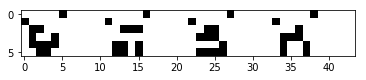

Target


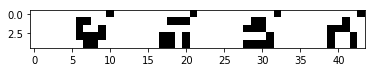

Predicted


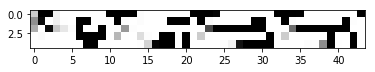

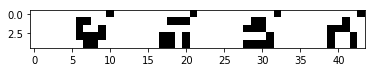

('Iteration', 41000, 'Train loss:', 0.0010547237515340898)
Test loss:  0.000457971000801
Input


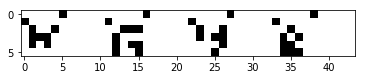

Target


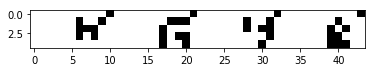

Predicted


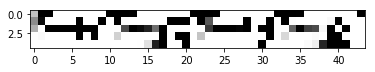

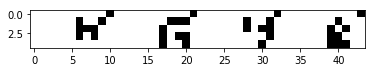

('Iteration', 42000, 'Train loss:', 0.0084464573686740541)
Test loss:  0.000592633772121
Input


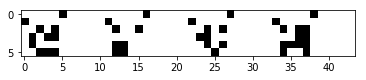

Target


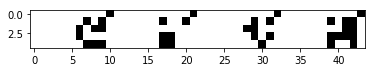

Predicted


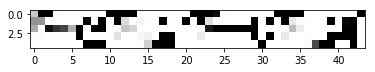

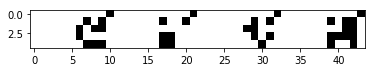

('Iteration', 43000, 'Train loss:', 0.0078209841913673573)
Test loss:  0.000352947142085
Input


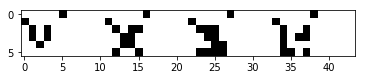

Target


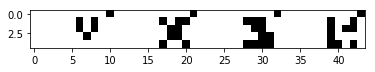

Predicted


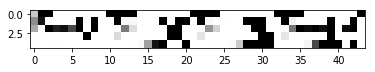

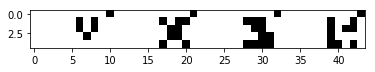

('Iteration', 44000, 'Train loss:', 0.00011536174697848351)
Test loss:  0.000114454010622
Input


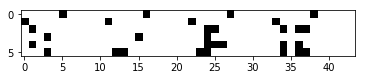

Target


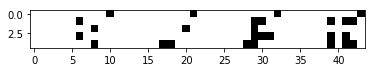

Predicted


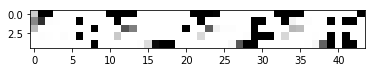

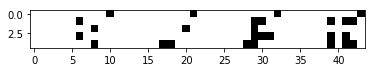

('Iteration', 45000, 'Train loss:', 0.00017295842875684087)
Test loss:  0.000108152053544
Input


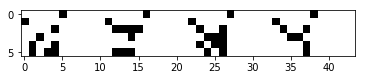

Target


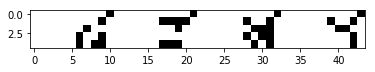

Predicted


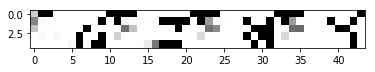

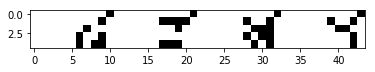

('Iteration', 46000, 'Train loss:', 0.0001957530688613885)
Test loss:  9.61658046347e-05
Input


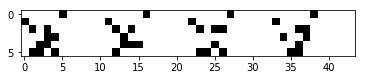

Target


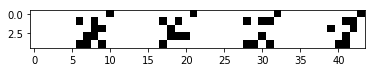

Predicted


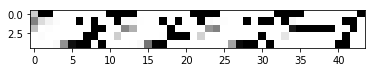

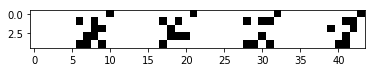

('Iteration', 47000, 'Train loss:', 5.0903803086346742e-05)
Test loss:  0.000141438863583
Input


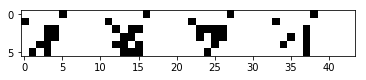

Target


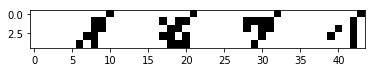

Predicted


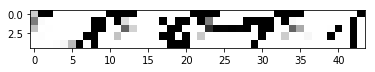

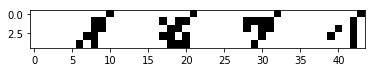

('Iteration', 48000, 'Train loss:', 2.4419468502556738e-05)
Test loss:  0.000472896270746
Input


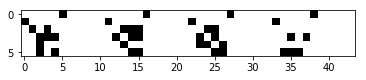

Target


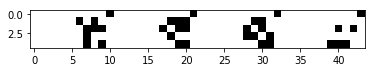

Predicted


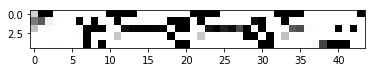

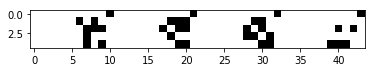

('Iteration', 49000, 'Train loss:', 0.019465714890035218)
Test loss:  0.00029659489419
Input


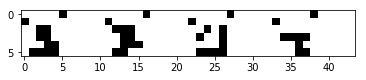

Target


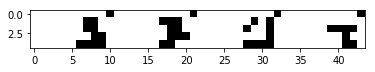

Predicted


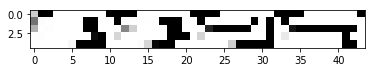

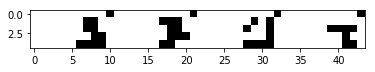

('Iteration', 50000, 'Train loss:', 3.7758576728990614e-05)
Test loss:  5.74966684074e-05
Input


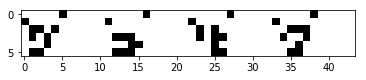

Target


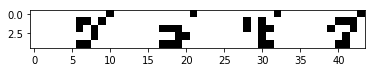

Predicted


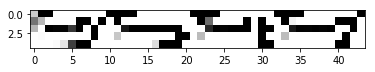

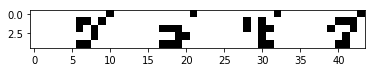

('Iteration', 51000, 'Train loss:', 0.00037281604131863725)
Test loss:  6.80205490859e-05
Input


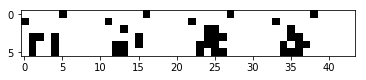

Target


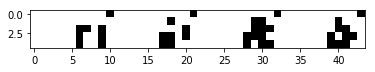

Predicted


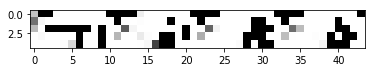

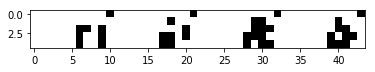

('Iteration', 52000, 'Train loss:', 3.372541259891658e-05)
Test loss:  3.84364893064e-05
Input


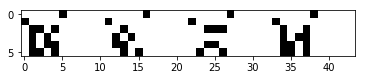

Target


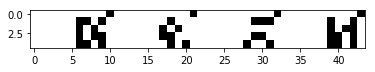

Predicted


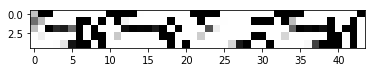

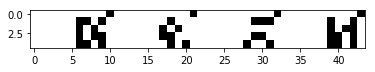

('Iteration', 53000, 'Train loss:', 1.0403241454058697e-05)
Test loss:  3.05163242077e-05
Input


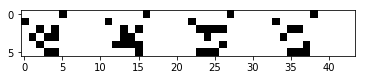

Target


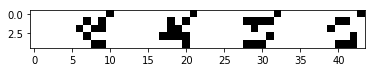

Predicted


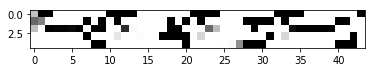

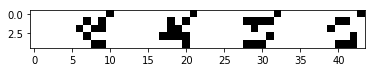

('Iteration', 54000, 'Train loss:', 1.5792911587895756e-05)
Test loss:  1.78855968253e-05
Input


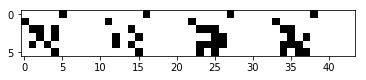

Target


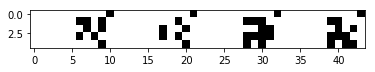

Predicted


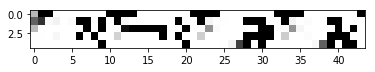

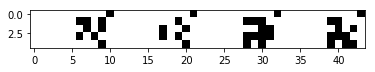

In [ ]:
## Testing recurrent DNC


def loss_fn(pred, target, mask):
    pred = sigmoid(pred)
    one = np.ones_like(pred)
    epsilon = 1.e-20 # to prevent log(0)
    a = target * np.log(pred + epsilon)
    b = (one - target) * np.log(one - pred + epsilon)
    return np.mean(- (a + b) * mask)

# def loss_fn(pred, target, mask):
#     pred = sigmoid(pred)
#     l2 = np.sqrt(np.square(pred - target))
#     return np.mean(l2 * mask)

def l2(x):
    """
    stable l2-norm
    """
    return np.sqrt(np.sum(np.multiply(x, x)) + 1.e-20) 

seq_len, seq_wid = 4, 4

# dnc = DNCFF(input_size=seq_wid+2, output_size=seq_wid+1, hidden_size=32, R=2, N=64, W=4)
dnc = DNC(input_size=seq_wid+2, output_size=seq_wid+1, hidden_size=32, R=2, N=64, W=8)
dnc_params = dnc._init_params()
# for k,v in dnc_params.items():
#     print k
#     print v.shape

def print_training_prediction(params, iters):
    
    inputs, targets, mask = long_copy(seq_len, seq_wid)
    result = []
    dnc = DNC(input_size=seq_wid+2, output_size=seq_wid+1, hidden_size=32, R=2, N=64, W=8)
    for t in range(inputs.shape[0]):
        out = dnc.step_forward(params, inputs[np.newaxis, t])
        result.append(out)
    result = np.concatenate(result, axis=0)
    loss = loss_fn(result, targets, mask)
    print "Test loss: ", loss
#     reg = l2(params['W_1']) + l2(params['W_2']) + l2(params['b_1']) + l2(params['b_2'])
#     print "Param Mag: ", 5e-4 * reg
    print "Input"
    display(inputs.T)
    print "Target"
    display(targets.T)
    print "Predicted"
    display((sigmoid(result)).T)
    display(np.around((sigmoid(result) * mask), decimals=0).astype('int').T)
    
    # Saving Model Check Points
    save_pickle(params, './ckpt_copy_long/Iter_%d_Loss_%.6f.pkl' % (iters, loss))

    
def training_loss(params, iters):
    inputs, targets, mask = long_copy(seq_len, seq_wid)
    result = []
    dnc = DNC(input_size=seq_wid+2, output_size=seq_wid+1, hidden_size=32, R=2, N=64, W=8)
    for t in range(inputs.shape[0]):
        out = dnc.step_forward(params, inputs[np.newaxis, t])
        result.append(out)
    result = np.concatenate(result, axis=0)
#     # regularization
#     reg = l2(params['W_1']) + l2(params['W_2']) + l2(params['b_1']) + l2(params['b_2'])
    return loss_fn(result, targets, mask) # + 5.e-4 * reg

def callback(weights, iters, gradient):
    if iters % 1000 == 0:
        print("Iteration", iters, "Train loss:", training_loss(weights, 0))
        print_training_prediction(weights, iters)

# Build gradient of loss function using autograd.
training_loss_grad = grad(training_loss)

print("Training DNC...")
# trained_params = adam(training_loss_grad, dnc_params, step_size=0.001,
#                       num_iters=1000000, callback=callback)
trained_params = rmsprop(training_loss_grad, dnc_params, step_size=0.001,
                      num_iters=1000000, callback=callback)